In [1]:
from joblib import load
import numpy as np
import pandas as pd
import spacy
import re
from fractions import Fraction
from decimal import Decimal, InvalidOperation
import unicodedata
import sys
sys.path.append("..")
from src.data import data_cleaning_util
from src.features import create_features
import matplotlib.pyplot as plt

### Plots of data

In [2]:
epi_data_df = pd.read_hdf('../data/processed/epi_vector.h5')


In [3]:
sample_df = epi_data_df.head(9000)

In [4]:
count = sample_df['tags'].apply(pd.Series).stack().unique()

In [5]:
sample_df.head(3)

,""" 00 "" (soft wheat) flour * or cake flour",""" 00 "" flour",""" 00 "" flour, divide",""" > chicken stock chicken broth",""" > panko (japanese bread crumb bread crumb",""" baby "" Pattypan squash",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" circular wire rack",...,ﬁne dry bread crumb,ﬁne salt,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,0.85,25.0,0.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,4.0,0.0,0.67,3.0,0.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.75,4.0,0.0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"


In [6]:
corr_df = sample_df[['avg_rating','best_rating','prepare_again_rating','num_reviews','title']]

In [7]:
corr_df.head(3)

,avg_rating,best_rating,prepare_again_rating,num_reviews,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,2.5,4.0,0.85,25.0,"""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,3.5,4.0,0.67,3.0,"""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,3.0,4.0,0.75,4.0,"""Blanketed"" Eggplant"


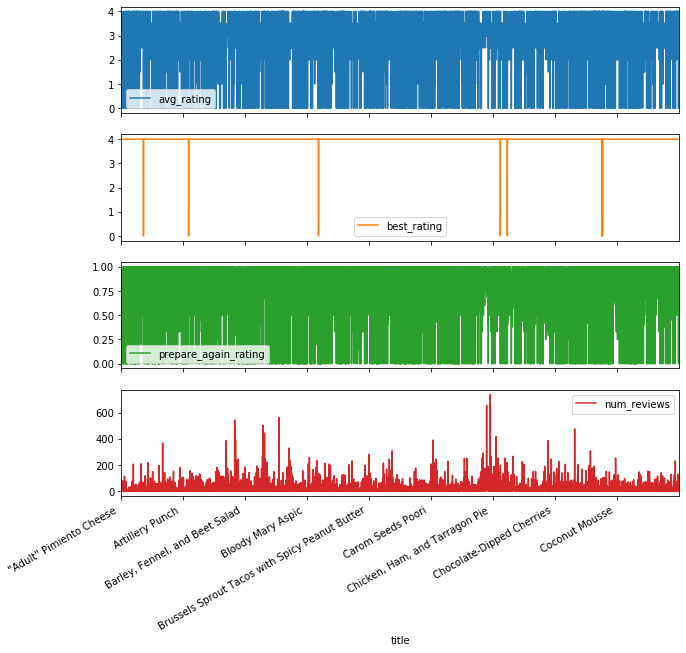

In [8]:
# correlation between name
corr_df.plot.line(x='title',subplots=True,figsize=(10,10))
plt.show()

https://www.dummies.com/education/math/statistics/how-to-interpret-a-correlation-coefficient-r/

In [10]:
corr_df.corr()

,avg_rating,best_rating,prepare_again_rating,num_reviews
avg_rating,1.000000,0.087713,0.821065,0.229937
best_rating,0.087713,1.000000,0.077943,0.017554
prepare_again_rating,0.821065,0.077943,1.000000,0.221306
num_reviews,0.229937,0.017554,0.221306,1.000000


In [24]:
from collections import Counter
c = Counter()  
epi_data_df["tags"].apply(lambda x: c.update(x))
# print(c)

http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852                                                         None
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430                                                              None
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305                                                               None
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813                        None
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932                                                   None
                                                                                                                                   ... 
http://www.epicurious.com/recipes/food/views/zuni-roast-chicken-with-bread-salad-56389456                                          None
http://www.epicurious.com/recipes/food/views/zun

In [23]:
count = pd.DataFrame()
c
count['tags_count'] = [c[i] for i in c]
count['tag'] = [i for i in c]
count = count.sort_values(by='tags_count',ascending=False)

# delete row with value < n
indexNames = count[ count['tags_count'] <= 50 ].index
 
# Delete these row indexes from dataFrame
count.drop(indexNames , inplace=True)
count

,tags_count,tag
19,16546,Peanut Free
20,16106,Soy Free
17,15226,Bon Appétit
34,14030,Tree Nut Free
3,13382,Vegetarian
...,...,...
490,52,Kumquat
329,52,Scotch
532,52,Pennsylvania
215,52,Rutabaga


In [ ]:
# epi_data_df.corr()

### Random data

Following this linke:

https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

In [5]:
import random
df = pd.DataFrame()
wc = ['Bad','Good']
dc = ['Sober','Alcohol-impaired']
tv = ['None','Disobey stop sign','Exceed speed limit','Disobey traffic signal']
sb = ['yes','no']
cs = ['Minor','Major']
df['Weather Condition'] = np.random.choice(wc,1000,p=[0.4,0.6]) 
df['Driver Condition'] = np.random.choice(dc,1000,p=[0.5,0.5]) 
df['Traffic Violation'] = np.random.choice(tv,1000,p=[0.1,0.4,0.3,0.2])
df['Seat Belt'] = np.random.choice(sb,1000,p=[0.7,0.3])
df['Crash Severity'] = np.random.choice(cs,1000,p=[0.6,0.4])
# df.loc[df['Weather Condition']=='Good']

def weight_prob(row):
    if row["Driver Condition"] == 'Alcohol-impaired' and np.random.random() >=0.4:
        row["Crash Severity"] = 'Major'
    return row
df.apply(weight_prob, axis=1)
df

,Weather Condition,Driver Condition,Traffic Violation,Seat Belt,Crash Severity
0,Bad,Sober,Exceed speed limit,yes,Minor
1,Good,Sober,Disobey stop sign,yes,Minor
2,Good,Alcohol-impaired,Disobey stop sign,yes,Major
3,Good,Sober,Disobey stop sign,no,Minor
4,Bad,Sober,Disobey stop sign,no,Minor
...,...,...,...,...,...
995,Bad,Alcohol-impaired,Disobey stop sign,no,Major
996,Good,Alcohol-impaired,None,yes,Major
997,Good,Alcohol-impaired,Exceed speed limit,yes,Major
998,Good,Alcohol-impaired,Exceed speed limit,yes,Major


In [6]:
# df['Crash Severity'].loc[df['Crash Severity']=='Major'] =1
# df['Crash Severity'].loc[df['Crash Severity']=='Minor'] =0
# df = pd.read_csv('iris.csv')
# df

In [7]:
# Seperate data from attribute we will used to classify, 
# which is class.

X = df.drop('Crash Severity', axis=1)
Y = df['Crash Severity']
print(Y.head())
X.head()

0    Minor
1    Minor
2    Major
3    Minor
4    Minor
Name: Crash Severity, dtype: object


,Weather Condition,Driver Condition,Traffic Violation,Seat Belt
0,Bad,Sober,Exceed speed limit,yes
1,Good,Sober,Disobey stop sign,yes
2,Good,Alcohol-impaired,Disobey stop sign,yes
3,Good,Sober,Disobey stop sign,no
4,Bad,Sober,Disobey stop sign,no


In [8]:
from sklearn import preprocessing
# label encoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers

Y = le.fit_transform(Y)
weather_encoded = le.fit_transform(X['Weather Condition'])
X['Weather_Condition'] = weather_encoded
driver_encoded = le.fit_transform(X['Driver Condition'])
X['Driver_Condition'] = driver_encoded
traffic_encoded = le.fit_transform(X['Traffic Violation'])
X['Traffic_Violation'] = traffic_encoded
seat_encoded = le.fit_transform(X['Seat Belt'])
X['Seat_Belt'] = seat_encoded
# print(X.Weather_Condition)
X

,Weather Condition,Driver Condition,Traffic Violation,Seat Belt,Weather_Condition,Driver_Condition,Traffic_Violation,Seat_Belt
0,Bad,Sober,Exceed speed limit,yes,0,1,2,1
1,Good,Sober,Disobey stop sign,yes,1,1,0,1
2,Good,Alcohol-impaired,Disobey stop sign,yes,1,0,0,1
3,Good,Sober,Disobey stop sign,no,1,1,0,0
4,Bad,Sober,Disobey stop sign,no,0,1,0,0
...,...,...,...,...,...,...,...,...
995,Bad,Alcohol-impaired,Disobey stop sign,no,0,0,0,0
996,Good,Alcohol-impaired,None,yes,1,0,3,1
997,Good,Alcohol-impaired,Exceed speed limit,yes,1,0,2,1
998,Good,Alcohol-impaired,Exceed speed limit,yes,1,0,2,1


In [10]:
x = list(zip(X.Weather_Condition,X.Driver_Condition,X.Traffic_Violation))
# x

In [13]:
x[:10]

[(0, 1, 2),
 (1, 1, 0),
 (1, 0, 0),
 (1, 1, 0),
 (0, 1, 0),
 (1, 1, 1),
 (1, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 0, 0)]

In [14]:
from sklearn.naive_bayes import GaussianNB

# create a guassian classifier
model = GaussianNB()
model.fit(x,Y)
print(model.epsilon_)

1.0975110000000008e-09


In [17]:
# predict outputs
v = (5.1, 3.5, 1.4, 0.2) # 
predicted = model.predict(x)
print("Predicted value ", predicted[:10])

Predicted value  [1 1 0 1 1 1 1 1 1 0]


### Multiple Label classifier

In [27]:
X = pd.DataFrame()
Y = pd.DataFrame()
X = df.drop('Crash Severity', axis=1)
X = X.drop('Seat Belt',axis=1)
Y['Crash Severity'] = df['Crash Severity']
Y['Seat Belt'] = df['Seat Belt']
print(Y.head())
X.head()

  Crash Severity Seat Belt
0          Minor       yes
1          Minor       yes
2          Major       yes
3          Minor        no
4          Minor        no


,Weather Condition,Driver Condition,Traffic Violation
0,Bad,Sober,Exceed speed limit
1,Good,Sober,Disobey stop sign
2,Good,Alcohol-impaired,Disobey stop sign
3,Good,Sober,Disobey stop sign
4,Bad,Sober,Disobey stop sign


In [29]:
from sklearn import preprocessing
# label encoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers

seat_belt_encoded = le.fit_transform(Y['Seat Belt'])
Y['Seat_Belt'] = seat_belt_encoded
crash_encoded = le.fit_transform(Y['Crash Severity'])
Y['Crash_Severity'] = crash_encoded
weather_encoded = le.fit_transform(X['Weather Condition'])
X['Weather_Condition'] = weather_encoded
driver_encoded = le.fit_transform(X['Driver Condition'])
X['Driver_Condition'] = driver_encoded
traffic_encoded = le.fit_transform(X['Traffic Violation'])
X['Traffic_Violation'] = traffic_encoded
print(Y.head())
# print(X.Weather_Condition)
X

  Crash Severity Seat Belt  Seat_Belt  Crash_Severity
0          Minor       yes          1               1
1          Minor       yes          1               1
2          Major       yes          1               0
3          Minor        no          0               1
4          Minor        no          0               1


,Weather Condition,Driver Condition,Traffic Violation,Weather_Condition,Driver_Condition,Traffic_Violation
0,Bad,Sober,Exceed speed limit,0,1,2
1,Good,Sober,Disobey stop sign,1,1,0
2,Good,Alcohol-impaired,Disobey stop sign,1,0,0
3,Good,Sober,Disobey stop sign,1,1,0
4,Bad,Sober,Disobey stop sign,0,1,0
...,...,...,...,...,...,...
995,Bad,Alcohol-impaired,Disobey stop sign,0,0,0
996,Good,Alcohol-impaired,None,1,0,3
997,Good,Alcohol-impaired,Exceed speed limit,1,0,2
998,Good,Alcohol-impaired,Exceed speed limit,1,0,2


In [46]:
x = list(zip(X.Weather_Condition,X.Driver_Condition,X.Traffic_Violation))
# x
y = Y.Crash_Severity + Y.Seat_Belt
# print(y)
# y = list(zip(Y.Crash_Severity,Y.Seat_Belt))
# x
print(x[:5])
print("\n\n",y[:5])

[(0, 1, 2), (1, 1, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0)]


 0    2
1    2
2    1
3    1
4    1
dtype: int64


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=109)

In [49]:
from sklearn.naive_bayes import GaussianNB

# create a guassian classifier
model = GaussianNB()
# print(len(X_train))
# print(len(y_train))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)
# print(model.epsilon_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1
 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 2 2 1 2 2 1 1 2 1 1 2 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1
 2 1 1 2 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1
 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 2 2 2 1 1 1 2 1 1 1 2 1 1 1 1 2
 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1
 1 1 2 1]


From this link:

https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/

In [51]:
from sklearn.svm import SVC as svc
svclassifier = svc(kernel='linear')
svclassifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [53]:
y_pred = svclassifier.predict(X_test)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  0  55   0]
 [  0 151   0]
 [  0  94   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.50      1.00      0.67       151
           2       0.00      0.00      0.00        94

    accuracy                           0.50       300
   macro avg       0.17      0.33      0.22       300
weighted avg       0.25      0.50      0.34       300



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
